For rendered results see [http://www.thp.uni-koeln.de/~dsuess/visualization.html}](http://www.thp.uni-koeln.de/~dsuess/visualization.html)

In [1]:
cd ..

/Users/dsuess/Code/Machine Learning


In [2]:
import numpy as np
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

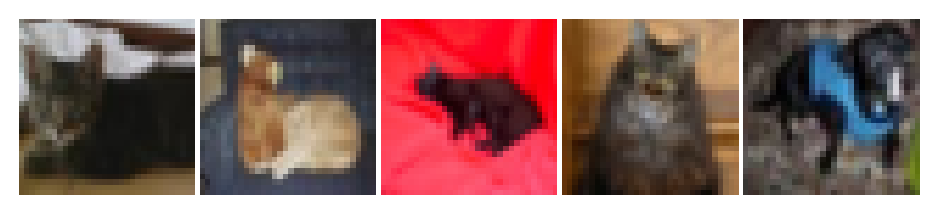

In [6]:
from keras.datasets import cifar10
# see github.com/dseuss/Pythonlibs
from tools.plot import rgb2gray, imsshow

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


LABELS = np.r_[y_train, y_test].ravel()
sel = (LABELS == 3) + (LABELS == 5)
IMAGES = np.r_[x_train, x_test][sel]
LABELS = LABELS[sel]

label_to_name = {3: 'cat', 5: 'dog'}
imsshow(IMAGES[:5]);

In [11]:
from tempfile import TemporaryDirectory
from tools.helpers import mkdir, Progress
import png

IMAGE_URL = 'http://www.thp.uni-koeln.de/~dsuess/cnd_thumpnails/'
# 
#mkdir(IMAGE_URL)
#for index, img in enumerate(Progress(IMAGES)):
#    new_img_path = IMAGE_URL + '{}.png'.format(index)
#    png.from_array(img, 'RGB').save(new_img_path)

In [9]:
import bokeh as bk
import bokeh.plotting as pl
import matplotlib as mpl

def safe_min(x, **kwargs):
    try:
        return np.min(x, **kwargs)
    except ValueError:
        return np.inf
    
def imgscatter(x_embed, idx=None, title="", imgurl=IMAGE_URL):
    idx = np.arange(len(x_embed)) if idx is None else idx
    mpl_colors = mpl.cm.Set1(mpl.colors.Normalize()(LABELS[idx]))
    src = pl.ColumnDataSource(data=dict(
        x=x_embed[:, 0],
        y=x_embed[:, 1],
        img_src=[IMAGE_URL + '{}.png'.format(i) for i in idx],
        desc=[label_to_name[label] for label in LABELS[idx]],
        color=["#%02x%02x%02x" % (int(r), int(g), int(b)) 
                    for r, g, b, _ in 255 * mpl_colors],
        idx=idx
    ))
    
    hover = bk.models.HoverTool(tooltips="""
        <div>
           <img src="@img_src" height=256 width=256 alt="@img_src"></img>
           <span style='font-size:18pt'>@desc (@idx)</span>
        </div>
    """)
    tools = [hover, 'box_select', 'box_zoom', 'pan', 'wheel_zoom']
    fig = pl.figure(tools=tools, title=title)
    fig.scatter('x', 'y', fill_color='color', source=src, 
                line_width=0, size=8, line_color='#000000')
    return fig

# PCA

In [12]:
from sklearn.decomposition import PCA

sel = np.random.choice(len(IMAGES), size=1000, replace=False)
mf = PCA(n_components=2)
x = IMAGES
x = x.reshape((len(x), -1))
# normalize each image s.t. every image has the same impact on PCA
x = x / np.linalg.norm(x, axis=-1, keepdims=True)
x_embed = mf.fit_transform(x)
pl.show(imgscatter(x_embed[sel], idx=sel, title='PCA'))

It looks like the two largest singular vectors correspond to the following patters:
- the largest singular vector (plotted along the `x` axis) corresponds to bright a bright center of the image independent of the color
- the second largest singular vector (plotted along the `y` axis) corresponds to a bright area in the top of the image

To check this, we show the images corresponding to the the singular vectors. Since they correspond to RGB images, we show the positive part on the left and the negative part on the right. Another strategy would be to use a diverging colormap for each channel seperately.

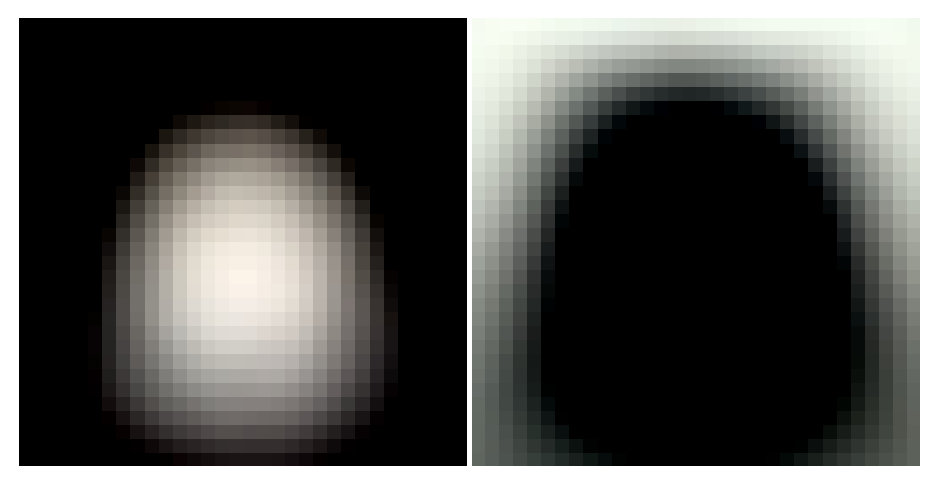

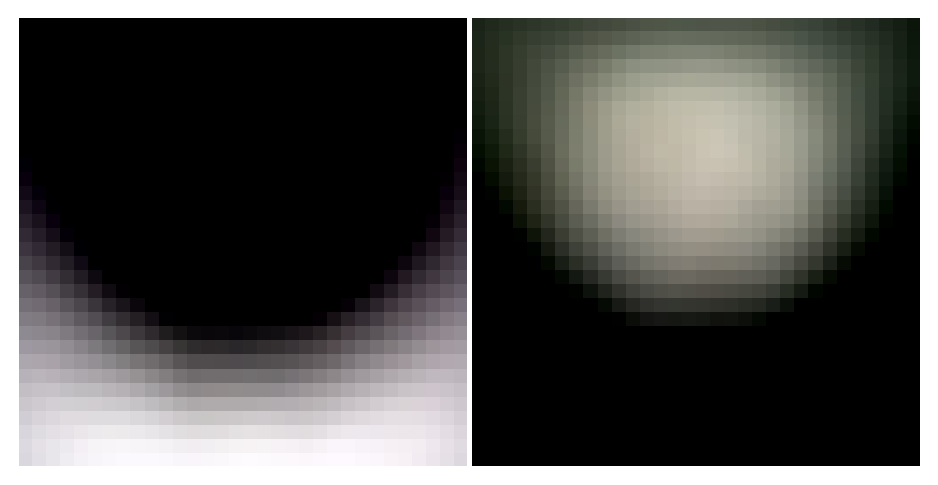

In [13]:
components = mf.components_.reshape((-1, 32, 32, 3))

def renormalize_img(img):
    return (255 * img / np.max(np.abs(img))).astype(np.uint8)

for comp in components:
    img = renormalize_img(comp)
    img_neg = -img * (comp < 0)
    img_pos = img * (comp >= 0)
    imsshow([img_pos, img_neg], grid=(2, 1))
    mpl.pyplot.show()

Of course, this kind of pattern is completely useless for distinguishing between cats and dogs, hence PCA fails to separate the two classes in the visualization.

# Others

In [14]:
from sklearn.manifold import MDS

sel = np.random.choice(len(IMAGES), size=1000, replace=False)
mf = MDS(n_components=2)
x = IMAGES[sel]
x = x.reshape((len(x), -1))
x = x / np.linalg.norm(x, axis=-1, keepdims=True)
x_embed = mf.fit_transform(x)
pl.show(imgscatter(x_embed, idx=sel, title='MDS'))

In [15]:
from sklearn.manifold import Isomap

sel = np.random.choice(len(IMAGES), size=2000, replace=False)
mf = Isomap(n_components=2)
x = IMAGES[sel]
x = x.reshape((len(x), -1))
x = x / np.linalg.norm(x, axis=-1, keepdims=True)
x_embed = mf.fit_transform(x)
pl.show(imgscatter(x_embed, idx=sel, title='Isomap'))

In [16]:
from sklearn.manifold import TSNE

sel = np.random.choice(len(IMAGES), size=2000, replace=False)
mf = TSNE(n_components=2, perplexity=50, learning_rate=200)
x = IMAGES[sel]
x = x.reshape((len(x), -1))
# normalize each image s.t. every image has the same impact on PCA
x = x / np.linalg.norm(x, axis=-1, keepdims=True)
x_embed = mf.fit_transform(x)
pl.show(imgscatter(x_embed, idx=sel, title='TSNE'))

Most of the results look quite similar (and not very informative). The main reason is probably that $\ell_2$ distance is very bad for distinguishing similar-looking images, let alone the content of the picture. A good example are the four following pictures. The pictures in each row where quite close to each other in the TSNE plot.


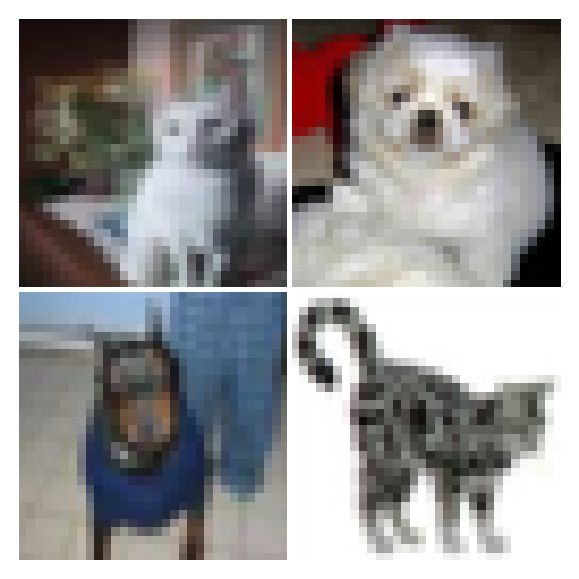

In [17]:
imsshow([IMAGES[index] for index in [3914, 8412, 9134, 2191]], 
        grid=(2, 2))

# Feature Extractor

In [47]:
from keras import backend
backend.set_image_data_format('channels_last')
from keras.models import load_model, Model
from keras.utils.data_utils import get_file

In [48]:
def preprocess(imgs):
    x = imgs.astype(np.double)
    # normalize to zero-mean pixels
    pixel_means = np.mean(x, axis=(0, 1, 2), keepdims=True)
    x -= pixel_means
    # RGB -> BGR
    x = x[..., ::-1]
    return x

MODEL_URL = "https://github.com/dseuss/ml-experiments/releases/download/cifar10/cifar10_reduced.h5"
model_path = get_file('cinfar10_reduced.h5', MODEL_URL)

model = load_model(model_path)
x_preprocessed = preprocess(IMAGES)
y_pred = model.predict_classes(x_preprocessed)
y_ref = (LABELS == 3).astype(int)
print("Performance of classifier on train & test set: {}"
      .format(np.mean(y_ref == y_pred.ravel())))

12000/12000 [==============================] - 54s      

In [49]:
encoder_output = model.get_layer('flatten').output
encoder = Model(inputs=model.inputs, outputs=encoder_output)
x_encoded = encoder.predict(x_preprocessed)

In [54]:
sel = np.random.choice(len(IMAGES), size=2000, replace=False)
mf = PCA(n_components=2)
x = x_encoded
# normalize each image s.t. every image has the same impact on PCA
x_embed = mf.fit_transform(x)
pl.show(imgscatter(x_embed[sel], idx=sel, title='PCA'))

In [57]:
sel = np.random.choice(len(IMAGES), size=1000, replace=False)
mf = MDS(n_components=2)
x = x_encoded[sel]
# normalize each image s.t. every image has the same impact on PCA
x_embed = mf.fit_transform(x)
pl.show(imgscatter(x_embed, idx=sel, title='MDS'))

In [58]:
sel = np.random.choice(len(IMAGES), size=2000, replace=False)
mf = Isomap(n_components=2)
x = x_encoded[sel]
# normalize each image s.t. every image has the same impact on PCA
x_embed = mf.fit_transform(x)
pl.show(imgscatter(x_embed, idx=sel, title='Isomap'))

In [59]:
sel = np.random.choice(len(IMAGES), size=2000, replace=False)
mf = TSNE(n_components=2, perplexity=50, learning_rate=200)
x = x_encoded[sel]
# normalize each image s.t. every image has the same impact on PCA
x_embed = mf.fit_transform(x)
pl.show(imgscatter(x_embed, idx=sel, title='TSNE'))

- TODO: Use the large-scale methods from the original TSNE paper to apply it to the full dataset
- TODO Refactor the whole plotting thing
- TODO Interpretation of the encoded results